In [15]:
from importlib import reload

import universe
reload(universe)
from universe import *

import projection_kernel
reload(projection_kernel)
from projection_kernel import *

import p2d
reload(p2d)
from p2d import *

In [26]:
dss = 1.
lMin = 20.   
lMax = 3.e3  
nL = 101
fsky = 1.
L, dL, Nmodes, Le = generateEllBins(lMin, lMax, nL, fsky) 
paramsUnivPlanck15 = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
            #       'l_max_scalars': 2000,
            #       'lensing': 'yes',
                    'A_s': 2.3e-9,
                    'n_s': 0.9624,
                    'h': 0.6712,
                    'N_ur': 3.046,
                    'Omega_b': 0.0493,
                    'Omega_cdm': 0.267,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
                    }
paramsHigh = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
                    #'l_max_scalars': 2000,
                    #'lensing': 'yes',
                    'A_s': 2.3e-9 + dss*1.e-10,
                    'n_s': 0.9624 + dss*0.01,
                    'h': 0.6712 + dss*0.1,
                    #'N_ur': 3.046,
                    'Omega_b': 0.0493 + dss*0.0018,
                    'Omega_cdm': 0.267 + dss*0.0066,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
            }
paramsLow = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
                    #'l_max_scalars': 2000,
                    #'lensing': 'yes',
                    'A_s': 2.3e-9 - dss*1.e-10,
                    'n_s': 0.9624 - dss*0.01,
                    'h': 0.6712 - dss*0.1,
                    #'N_ur': 3.046,
                    'Omega_b': 0.0493 - dss*0.0018,
                    'Omega_cdm': 0.267 - dss*0.0066,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
            }

generate: 20.0, 3000.0


In [17]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u) 
    p2d_high = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
    p2d_low = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

def getCov(c1, Nmodes):
    nData = nL
    covMat = np.zeros((nData, nData))
    cov = lambda Pac, Pbd, Pad, Pbc, Npairs: np.diagflat((Pac * Pbd + Pad * Pbc) / Npairs)
    i1=0
    i2=0 
    p = c1.P1h+c1.P2h+c1.Pnoise 
    covBlock = cov(p, p, p, p, Nmodes)
    covMat[i1*nL:(i1+1)*nL, i2*nL:(i2+1)*nL] = covBlock
    return covMat 

def getFisher(c1, params, binedges, L, Nmodes):
    nPar=len(params)
    fisherData = np.zeros((nPar, nPar))
    cov = getCov(c1, Nmodes)
    invCov = np.linalg.inv(cov)
    for i in range(nPar):
        for j in range(nPar):
            di = getDerivative(params[i], binedges, L)
            dj = getDerivative(params[j], binedges, L)
            fisherData[i,j] = np.dot(di.transpose(), np.dot(invCov, dj))
    return fisherData
    

In [6]:
u = UnivPlanck15()

# computing the binedges for WeightTracerLSSTBins
w = WeightTracerLSSTSourcesDESCSRDV1(u)
nBins = 10
binedges = w.splitBins(nBins)

params = ['Omega_b', 'Omega_cdm']
w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
p2d = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
fisher = getFisher(p2d, params, binedges, L, Nmodes)


lsstsources: 27.0gal/arcmin^2
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
[[8.59442386e-18 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.22429274e-18 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.29430793e-18 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.60315769e-21
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.46031251e-21 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 7.32137033e-21]]
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsour

In [7]:
#calculating the covariance matrix

print(np.linalg.inv(fisher))

[[1.30434926e-05 1.97477444e-05]
 [1.97477444e-05 2.99037539e-05]]


### Checking $\sigma(f_{sky})$ behavior

I will now check the behavior of the errors as we change the fraction of the sky being used.

generate: 20.0, 3000.0
precomputing p2d lsstbins: 0.58 < z < 0.72lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d lsstbins: 0.0 < z < 0.31lsstsources
precomputing bare vs counter terms
lsstbins: 0.0 < z < 0.31: 2.7gal/arcmin^2
lsstsources: 27.0gal/arcmin^2
precomputing p2d

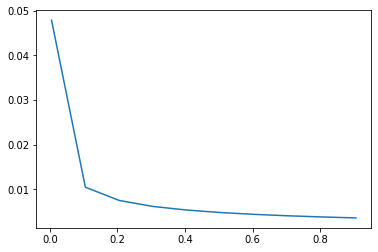

In [21]:
fskies = np.arange(0.005, 1., 0.1)
sigma_b = np.zeros(len(fskies))
sigma_cdm = np.zeros(len(fskies))
for i in range(len(fskies)):
    L_new, dL, Nmodes_new, Le = generateEllBins(lMin, lMax, nL, fskies[i])
    p2d_f = P2dCross(u, u, w_bin, w_other, lBins=L_new, nProc=3, save=True)
    fisher_f = getFisher(p2d_f, params, binedges, L_new, Nmodes_new)
    cov_f = np.linalg.inv(fisher_f)
    sigma_b[i]=np.sqrt(cov_f[0][0])
    sigma_cdm[i]=np.sqrt(cov_f[1][1])

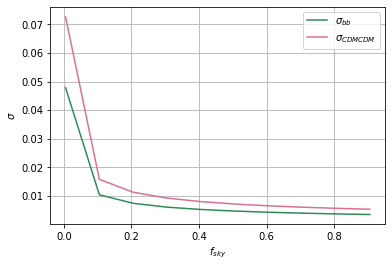

In [25]:
plt.plot(fskies, sigma_b, color='seagreen', label=r'$\sigma_{bb}$')
plt.plot(fskies, sigma_cdm, color='palevioletred', label=r'$\sigma_{CDMCDM}$')
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$f_{sky}$')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('/Users/anacarolinaoliveira/Downloads/fsky_sigma.pdf')

### Testing Fisher for other $C_{\ell}$

Now, let's go back to the fsky=1 cases, and the test will now be done for other power spectra. I modify the derivative function to get the fisher matrix for the cross-cross for 2 adjacent redshift bins.

In [11]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])
    p2d_high = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])
    p2d_low = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])

p2d_crossbins = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
fisher = getFisher(p2d_crossbins, params, binedges, L, Nmodes)

print(np.linalg.inv(fisher))

lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.72 < z < 0.87: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72lsstbins: 0.72 < z < 0.87
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.72 < z < 0.87: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72lsstbins: 0.72 < z < 0.87
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.72 < z < 0.87: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72lsstbins: 0.72 < z < 0.87
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.72 < z < 0.87: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72lsstbins: 0.72 < z < 0.87
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.72 < z < 0.87: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72lsstbins: 0.72 < z < 0.87
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
lsstbins: 0.

Now the auto-auto for 1 bin:

In [12]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    p2d_high = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    p2d_low = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])

p2d_auto = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
fisher = getFisher(p2d_auto, params, binedges, L, Nmodes)

print(np.linalg.inv(fisher))

lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins: 0.58 < z < 0.72: 2.7gal/arcmin^2
precomputing p2d lsstbins: 0.58 < z < 0.72bin
precomputing bare vs counter terms
lsstbins

### Cross check plotting